# XSSClassifier:  XSS Attack Detection Approach Based on Machine Learning Classifier in Python

### Research/Related Work

Based on the white paper, XSSClassifier: An Efficient XSS Attack Detection Approach Based on Machine Learning Classifier on SNSs:


https://pdfs.semanticscholar.org/2c74/d8e94b73c35e8651189262d0c7f32e6cfc7c.pdf?_ga=2.60428845.1871262773.1581209097-1873828646.1581209097


The Doc2Vec method, a concept that was presented in 2014 by Mikilov and Le, the underlying intuition of Doc2Vec is that the document representation should be good enough to predict the words in the document:
https://cs.stanford.edu/~quocle/paragraph_vector.pdf

scikit-learn is a Python module for machine learning:
https://github.com/scikit-learn/scikit-learn

XSS Machine Learning:
https://github.com/Xyntax/ML/blob/master/xss_word_vector/xss_wordvector.ipynb


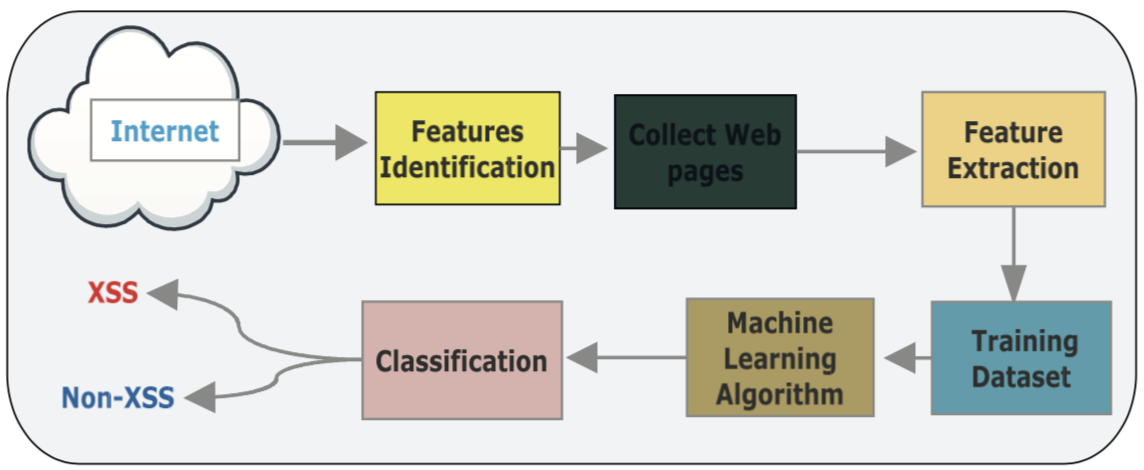
 
 
 ### Goal:
    Create a training algorithm for detecting an XSS attack vector in a Query Parameter string. 
    Define a set of features that we can use to train the model and label a sample as XSS(1) or Not XSS(0)
    Use a doc2vec vector to determine a vector for sample
    Use additional feature sets to improve the accuracy

## 1. Gather Test Data 
Get a list of samples and create an array with labels.

In [1]:
import sys
#!{sys.executable} -m pip install -U numpy
#!{sys.executable} -m pip install -U gensim
#!{sys.executable} -m pip install -U python-Levenshtein
#!{sys.executable} -m pip install -U nltk
#!{sys.executable} -m pip install -U scikit-learn
#Import all the dependencies
import warnings
#warnings.filterwarnings("ignore")
import nltk
nltk.download('punkt')

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from numpy import *
from urllib.parse import unquote

import numpy as np
import pandas as pd
import csv
import urllib.parse as parse
import pickle


testXSS = []
testNORM = []
X_temp = []
X = []
y = []
xssnum = 0
notxssnum = 0
print("Gathering Data...")
# gather the XSS string and append the label of 1 to y array
with open('lib/testXSS.txt', 'r', encoding='UTF-8') as f:
    testXSS = f.readlines()
print("*", sep=' ', end='', flush=True)
# parse out the query part of the URL 
for line in testXSS:
    query = parse.urlsplit(line)[3]
    #try to remove open redirect vulns
    if "?http" in str(line):
        continue
    if "?url=http" in str(line):
        continue
    if "?fwd=http" in str(line):
        continue
    if "?path=http" in str(line):
        continue
    if "=http" in str(query):
        continue
    if "page=search" in str(query):
        continue
    if len(query) > 8:
        xssnum += 1
        #X_temp.append(query)
        X_temp.append(line)
        
# remove duplicates
dedup = list(dict.fromkeys(X_temp))
print("*", sep=' ', end='', flush=True)
# Add a feature to X and label to the y array
for line in dedup:
    #print("XSS => "+line)
    X.append(line)
    y.append(1)
    
X_temp = []
dedup = []
print("*", sep=' ', end='', flush=True)

# gather the list of normal string and append the label of 0 to y array 
with open('lib/testNORM.txt', 'r', encoding='UTF-8') as f:
    testNORM = f.readlines()
    
# parse out the query part of the URL 
for line in testNORM:
    query = parse.urlsplit(line)[3]
    #if "http" in str(query):
    #    continue
    if len(query) > 3:
        notxssnum += 1
        X_temp.append(line)
        
# remove duplicates
dedup = list(dict.fromkeys(X_temp))
print("*", sep=' ', end='', flush=True)
# Add a feature to X and a label to the y array
for line in dedup:
    #print("NOT XSS => "+line)
    X.append(line)
    y.append(0)


# print(X)
# vec2d = [X,y]
# print(vec2d)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Gathering Data...
****

In [2]:
print("Number of XSS Samples: "+str(xssnum))
print("Number of NOT XSS Samples: "+str(notxssnum))
print("Total Samples: "+str(xssnum+notxssnum))

Number of XSS Samples: 38608
Number of NOT XSS Samples: 44826
Total Samples: 83434


##### The sample set collected was larger then the one used in the reasearch paper
```
We constructed a training dataset containing 1,000 webpages (400 malicious and 600 benign) and their extracted features.

- XSSClassifier: An Efficient XSS Attack Detection Approach Based on Machine Learning Classifier on SNSs
Shailendra Rathore*, Pradip Kumar Sharma*, and Jong Hyuk Park*
```
We could expand the data set and samples used to train the model.

Other resources for collecting sample data are listed below:

Benign:

https://raw.githubusercontent.com/Xyntax/ML/master/DL_for_xss/data/normal_examples.csv
https://raw.githubusercontent.com/Xyntax/ML/master/DL_for_xss/data/white.csv

Malicious:

https://gist.github.com/ThomasOrlita/e2e4a6d72877c8c897082eefe969578a
https://raw.githubusercontent.com/Xyntax/ML/master/DL_for_xss/data/xssed.csv
https://raw.githubusercontent.com/Xyntax/ML/master/DL_for_xss/data/black.csv
https://raw.githubusercontent.com/foospidy/payloads/master/other/xss/reddit_xss_get.txt
https://github.com/danielmiessler/SecLists/tree/master/Fuzzing/XSS


## 2. Create an array of the features for each test sample

Certain HTML tags can be used by an attacker to inject the XSS code scripts from outside. These HTML tags consist of ```<link>, <object>, <form>, <script>, <embed>, <ilayer>, <layer>, <style>, <applet>, <meta>, <img>, <iframe>```. 

On the other hand, JavaScript language is used in a webpage for embedding tasks, but an attacker can misuse some methods on the embedded XSS payload such as ```exec(), fromCharCode(), eval, alert(), getElementsByTagName(), write(), unscape(), and escape()```



In [3]:
# Create a function to convert an array of query strings to a set of features
def getVec(text):
    tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(text)]
    max_epochs = 25
    vec_size = 20
    alpha = 0.025

    model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=1)
    model.build_vocab(tagged_data)
    print("Building the sample vector model...")
    features = []
    for epoch in range(max_epochs):
        #print('Doc2Vec Iteration {0}'.format(epoch))
        print("*", sep=' ', end='', flush=True)
        model.random.seed(42)
        model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha
    model.save("lib/d2v.model")
    print()
    print("Model Saved")
    for i, line in enumerate(text):
        featureVec = [model.dv[i]]
        lineDecode = unquote(line)
        lineDecode = lineDecode.replace(" ", "")
        lowerStr = str(lineDecode).lower()
        #print("X"+str(i)+"=> "+line)
        # We could expand the features
        # https://websitesetup.org/javascript-cheat-sheet/
        # https://owasp.org/www-community/xss-filter-evasion-cheatsheet
        # https://html5sec.org/
        
        # add feature for malicious HTML tag count
        feature1 = int(lowerStr.count('<link'))
        feature1 += int(lowerStr.count('<object'))
        feature1 += int(lowerStr.count('<form'))
        feature1 += int(lowerStr.count('<embed'))
        feature1 += int(lowerStr.count('<ilayer'))
        feature1 += int(lowerStr.count('<layer'))
        feature1 += int(lowerStr.count('<style'))
        feature1 += int(lowerStr.count('<applet'))
        feature1 += int(lowerStr.count('<meta'))
        feature1 += int(lowerStr.count('<img'))
        feature1 += int(lowerStr.count('<iframe'))
        feature1 += int(lowerStr.count('<input'))
        feature1 += int(lowerStr.count('<body'))
        feature1 += int(lowerStr.count('<video'))
        feature1 += int(lowerStr.count('<button'))
        feature1 += int(lowerStr.count('<math'))
        feature1 += int(lowerStr.count('<picture'))
        feature1 += int(lowerStr.count('<map'))
        feature1 += int(lowerStr.count('<svg'))
        feature1 += int(lowerStr.count('<div'))
        feature1 += int(lowerStr.count('<a'))
        feature1 += int(lowerStr.count('<details'))
        feature1 += int(lowerStr.count('<frameset'))
        feature1 += int(lowerStr.count('<table'))
        feature1 += int(lowerStr.count('<comment'))
        feature1 += int(lowerStr.count('<base'))
        feature1 += int(lowerStr.count('<image'))
        # add feature for malicious method/event count
        feature2 = int(lowerStr.count('exec'))
        feature2 += int(lowerStr.count('fromcharcode'))
        feature2 += int(lowerStr.count('eval'))
        feature2 += int(lowerStr.count('alert'))
        feature2 += int(lowerStr.count('getelementsbytagname'))
        feature2 += int(lowerStr.count('write'))
        feature2 += int(lowerStr.count('unescape'))
        feature2 += int(lowerStr.count('escape'))
        feature2 += int(lowerStr.count('prompt'))
        feature2 += int(lowerStr.count('onload'))
        feature2 += int(lowerStr.count('onclick'))
        feature2 += int(lowerStr.count('onerror'))
        feature2 += int(lowerStr.count('onpage'))
        feature2 += int(lowerStr.count('confirm'))
        feature2 += int(lowerStr.count('marquee'))
        # add feature for ".js" count
        feature3 = int(lowerStr.count('.js'))
        # add feature for "javascript" count
        feature4 = int(lowerStr.count('javascript'))
        # add feature for length of the string
        feature5 = int(len(lowerStr))
        # add feature for "<script"  count
        feature6 = int(lowerStr.count('<script'))
        feature6 += int(lowerStr.count('&lt;script'))
        feature6 += int(lowerStr.count('%3cscript'))
        feature6 += int(lowerStr.count('%3c%73%63%72%69%70%74'))
        # add feature for special character count
        feature7 = int(lowerStr.count('&'))
        feature7 += int(lowerStr.count('<'))
        feature7 += int(lowerStr.count('>'))
        feature7 += int(lowerStr.count('"'))
        feature7 += int(lowerStr.count('\''))
        feature7 += int(lowerStr.count('/'))
        feature7 += int(lowerStr.count('%'))
        feature7 += int(lowerStr.count('*'))
        feature7 += int(lowerStr.count(';'))
        feature7 += int(lowerStr.count('+'))
        feature7 += int(lowerStr.count('='))
        feature7 += int(lowerStr.count('%3C'))
        # add feature for http count
        feature8 = int(lowerStr.count('http'))
        
        # append the features
        featureVec = np.append(featureVec,feature1)
        #featureVec = np.append(featureVec,feature2)
        featureVec = np.append(featureVec,feature3)
        featureVec = np.append(featureVec,feature4)
        featureVec = np.append(featureVec,feature5)
        featureVec = np.append(featureVec,feature6)
        featureVec = np.append(featureVec,feature7)
        #featureVec = np.append(featureVec,feature8)
        #print(featureVec)
        features.append(featureVec)
    return features

#### Using the function getVec(['data'])
```
testText = [
                'Search=%22%3E\'%3E%3CSCRIPT%20SRC=http://br.zone-h.org/testes/xss.js%3E%3C/SCRIPT%3E?',
                'id=15%3Cscript%3Ealert%28document.cookie%29%3C/script%3E',
                'composite_search=1&keyword="/><script>alert("Xss:Vijayendra")</script>'
            ]

Xnew = getVec(testText)
```

In [4]:
features = getVec(X)
features_dict = {'data':X,'features':features,'label':y}

Building the sample vector model...
*************************
Model Saved


### Features Data

In [5]:
# Ví dụ về 1 đường dẫn được gán nhãn là XSS
print("Test Sample: "+ X[0])
print("Features: " + str(features[0]))
print("\nLabel:\033[1;31;1m XSS(1)/\033[1;32;1m NOT XSS(0)\033[0;0m: " + str(y[0]))

Test Sample: http://search.rin.ru/cgi-bin/find.cgi?text=%3Cscript%3Ealert(%27HZ+iz+1337%27)%3B%3C%2Fscript%3E

Features: [ 2.36067748 -0.10220557  0.58003634 -0.46107468  0.90782386 -2.46432781
 -0.86877877 -1.48707938  0.69473225  3.12539911  1.72199094  1.53573799
  1.80842328  0.59923154 -0.43723437  3.28430104  1.84442306 -0.36585051
 -0.95692194 -0.62623447  0.          0.          0.         81.
  1.         15.        ]

Label: XSS(1)/ NOT XSS(0): 1


In [6]:
# Ví dụ về 1 đường dẫn được gán nhãn là NonXSS
print("Test Sample: "+ X[50000])
print("Features: " + str(features[50000]))
print("\nLabel:\033[1;31;1m XSS(1)/\033[1;32;1m NOT XSS(0)\033[0;0m: " + str(y[50000]))

Test Sample: http://stock.hankyung.com/apps/analysis.current?nid=01&itemcode=J57E399

Features: [-0.26144159  0.17284068  0.4264541   0.25438935 -0.22173755 -0.54222727
 -0.11526507  0.49848104 -0.70981467 -0.41133186  0.27667922 -0.13248205
  0.14670952  0.28080809 -0.29577148  0.49712157  0.57926095  0.25385848
  0.30541134 -0.27546105  0.          0.          0.         72.
  0.          7.        ]

Label: XSS(1)/ NOT XSS(0): 0


## 3. Train the Model

Train/Test split the training data

In [7]:
np.random.seed(42)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = .3, random_state=42)


In [8]:
# Use RandomState for reproducibility.
from sklearn import tree
my_classifier1 = tree.DecisionTreeClassifier(random_state=42)
print(my_classifier1)
print()

from sklearn.naive_bayes import GaussianNB
my_classifier2 = GaussianNB()
print(my_classifier2)
print()

from sklearn.linear_model import LogisticRegression 
my_classifier3 = LogisticRegression(max_iter= 60000)
print(my_classifier3)
print()

from sklearn.neighbors import KNeighborsClassifier
my_classifier4 = KNeighborsClassifier(n_neighbors=25, weights='uniform')
print(my_classifier4)
print()

from sklearn.ensemble import RandomForestClassifier
my_classifier5 = RandomForestClassifier(random_state=42)
print(my_classifier5)
print()

DecisionTreeClassifier(random_state=42)

GaussianNB()

LogisticRegression(max_iter=60000)

KNeighborsClassifier(n_neighbors=25)

RandomForestClassifier(random_state=42)



#### Additonal tunning of hyperparameters can be done.

I have only set the KNN n_neighbors weights

In [9]:
print("Training Classifier #1 DecisionTreeClassifier")
my_classifier1.fit(X_train, y_train)
print("Training Classifier #2 GaussianNB")
my_classifier2.fit(X_train, y_train)
print("Training Classifier #3 LogisticRegression")
my_classifier3.fit(X_train, y_train)
print("Training Classifier #4 KNeighborsClassifier")
my_classifier4.fit(X_train, y_train)
print("Training Classifier #5 RandomForestClassifier")
my_classifier5.fit(X_train, y_train)

predictions1 = my_classifier1.predict(X_test)
predictions2 = my_classifier2.predict(X_test)
predictions3 = my_classifier3.predict(X_test)
predictions4 = my_classifier4.predict(X_test)
predictions5 = my_classifier5.predict(X_test)

Training Classifier #1 DecisionTreeClassifier
Training Classifier #2 GaussianNB
Training Classifier #3 LogisticRegression
Training Classifier #4 KNeighborsClassifier
Training Classifier #5 RandomForestClassifier


## 4. Evaluation Metrics


### Predictions Results

Test the classifiers and compare the results of the models used.

### Training Accuracy Score

In [10]:
from sklearn.metrics import accuracy_score
print('Accuracy Score #1: {:.1%}'.format(accuracy_score(y_test, predictions1)))
print('Accuracy Score #2: {:.1%}'.format(accuracy_score(y_test, predictions2)))
print('Accuracy Score #3: {:.1%}'.format(accuracy_score(y_test, predictions3)))
print('Accuracy Score #4: {:.1%}'.format(accuracy_score(y_test, predictions4)))
print('Accuracy Score #5: {:.1%}'.format(accuracy_score(y_test, predictions5)))

Accuracy Score #1: 98.4%
Accuracy Score #2: 94.9%
Accuracy Score #3: 98.5%
Accuracy Score #4: 96.3%
Accuracy Score #5: 99.5%


### Classification Report

In [11]:
from sklearn.metrics import classification_report
print("Classification Report #1 DecisionTreeClassifier")
print(classification_report(y_test, predictions1, digits=4))
print("Classification Report #2 GaussianNB")
print(classification_report(y_test, predictions2, digits=4))
print("Classification Report #3 LogisticRegression")
print(classification_report(y_test, predictions3, digits=4))
print("Classification Report #4 KNeighborsClassifier")
print(classification_report(y_test, predictions4, digits=4))
print("Classification Report #5 RandomForestClassifier")
print(classification_report(y_test, predictions5, digits=4))

Classification Report #1 DecisionTreeClassifier
              precision    recall  f1-score   support

           0     0.9869    0.9839    0.9854     13437
           1     0.9814    0.9848    0.9831     11594

    accuracy                         0.9843     25031
   macro avg     0.9841    0.9844    0.9843     25031
weighted avg     0.9843    0.9843    0.9843     25031

Classification Report #2 GaussianNB
              precision    recall  f1-score   support

           0     0.9580    0.9461    0.9520     13437
           1     0.9384    0.9519    0.9451     11594

    accuracy                         0.9488     25031
   macro avg     0.9482    0.9490    0.9486     25031
weighted avg     0.9489    0.9488    0.9488     25031

Classification Report #3 LogisticRegression
              precision    recall  f1-score   support

           0     0.9792    0.9932    0.9862     13437
           1     0.9920    0.9756    0.9837     11594

    accuracy                         0.9851     25031


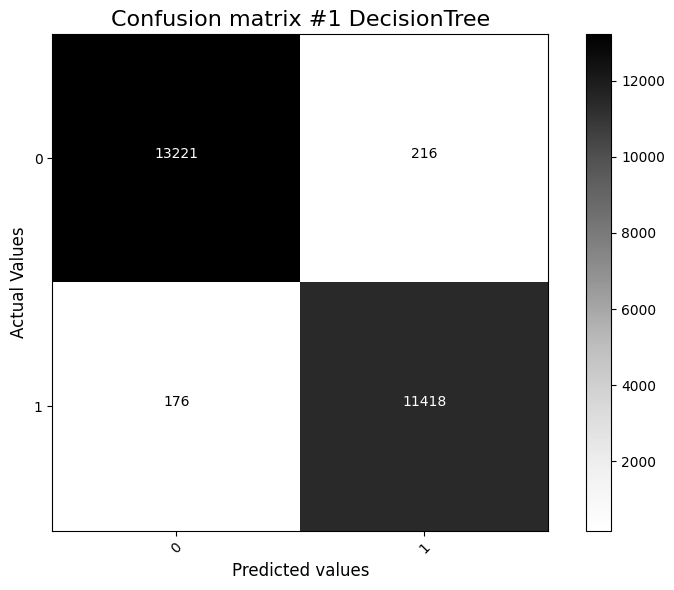

In [12]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# Danh sách dữ liệu mẫu y_true và y_pred
y_true = y_test

# Lấy các nhãn duy nhất từ y_true và y_pred để biết số lượng lớp
labels = np.unique(y_true)

# Tính confusion matrix
cm = confusion_matrix(y_true, predictions1, labels=labels)

# Chuẩn bị vẽ confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greys)
plt.title('Confusion matrix #1 DecisionTree', fontsize=16)
plt.colorbar()

# Định dạng các trục x và y
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Định dạng các giá trị trên ô
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Đặt tên trục và hiển thị
plt.ylabel('Actual Values', fontsize=12)
plt.xlabel('Predicted values', fontsize=12)
plt.tight_layout()
plt.show()

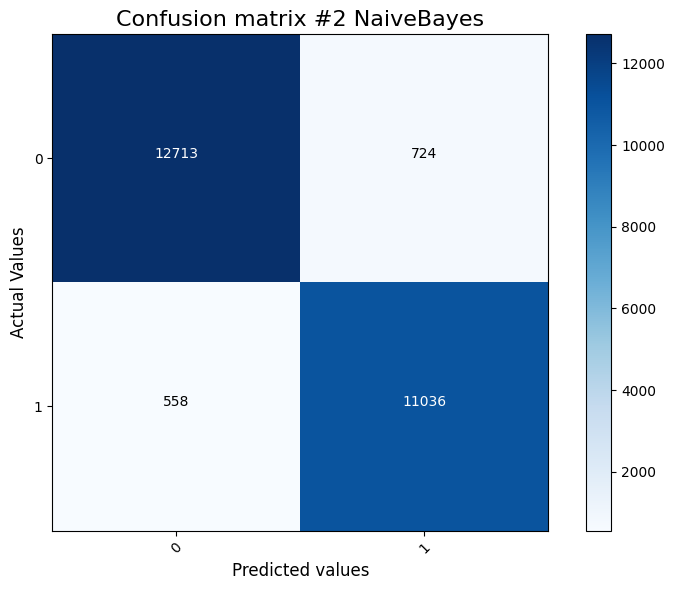

In [13]:
# Danh sách dữ liệu mẫu y_true và y_pred
y_true = y_test

# Lấy các nhãn duy nhất từ y_true và y_pred để biết số lượng lớp
labels = np.unique(y_true)

# Tính confusion matrix
cm = confusion_matrix(y_true, predictions2, labels=labels)

# Chuẩn bị vẽ confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix #2 NaiveBayes', fontsize=16)
plt.colorbar()

# Định dạng các trục x và y
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Định dạng các giá trị trên ô
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Đặt tên trục và hiển thị
plt.ylabel('Actual Values', fontsize=12)
plt.xlabel('Predicted values', fontsize=12)
plt.tight_layout()
plt.show()

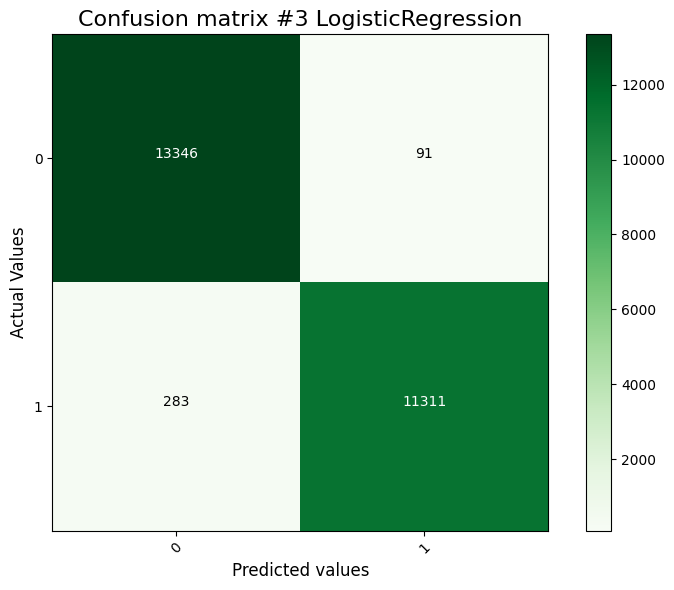

In [14]:
# Danh sách dữ liệu mẫu y_true và y_pred
y_true = y_test

# Lấy các nhãn duy nhất từ y_true và y_pred để biết số lượng lớp
labels = np.unique(y_true)

# Tính confusion matrix
cm = confusion_matrix(y_true, predictions3, labels=labels)

# Chuẩn bị vẽ confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix #3 LogisticRegression', fontsize=16)
plt.colorbar()

# Định dạng các trục x và y
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Định dạng các giá trị trên ô
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Đặt tên trục và hiển thị
plt.ylabel('Actual Values', fontsize=12)
plt.xlabel('Predicted values', fontsize=12)
plt.tight_layout()
plt.show()

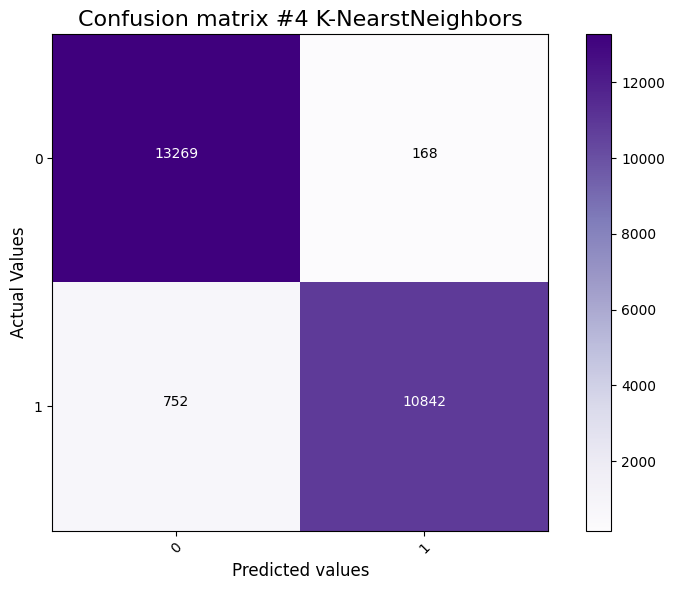

In [15]:
# Danh sách dữ liệu mẫu y_true và y_pred
y_true = y_test

# Lấy các nhãn duy nhất từ y_true và y_pred để biết số lượng lớp
labels = np.unique(y_true)

# Tính confusion matrix
cm = confusion_matrix(y_true, predictions4, labels=labels)

# Chuẩn bị vẽ confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion matrix #4 K-NearstNeighbors', fontsize=16)
plt.colorbar()

# Định dạng các trục x và y
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Định dạng các giá trị trên ô
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Đặt tên trục và hiển thị
plt.ylabel('Actual Values', fontsize=12)
plt.xlabel('Predicted values', fontsize=12)
plt.tight_layout()
plt.show()

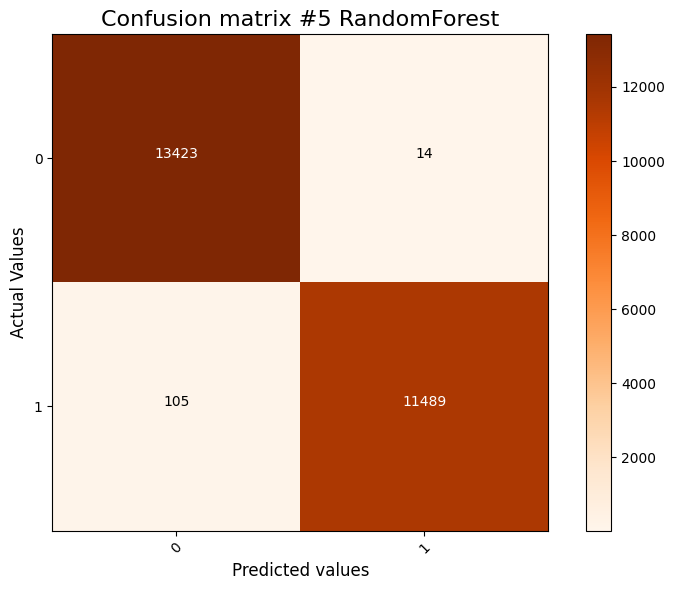

In [16]:
# Danh sách dữ liệu mẫu y_true và y_pred
y_true = y_test

# Lấy các nhãn duy nhất từ y_true và y_pred để biết số lượng lớp
labels = np.unique(y_true)

# Tính confusion matrix
cm = confusion_matrix(y_true, predictions5, labels=labels)

# Chuẩn bị vẽ confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title('Confusion matrix #5 RandomForest', fontsize=16)
plt.colorbar()

# Định dạng các trục x và y
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Định dạng các giá trị trên ô
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Đặt tên trục và hiển thị
plt.ylabel('Actual Values', fontsize=12)
plt.xlabel('Predicted values', fontsize=12)
plt.tight_layout()
plt.show()

## 5 . Retrain the Model with All the Data
Retrain the model with all the data gathered and then run some test with different input that is not included in the testing data

https://machinelearningmastery.com/make-predictions-scikit-learn/

In [17]:
print("Training Classifier #1 DecisionTreeClassifier")
my_classifier1.fit(features, y)

print("Training Classifier #2 GaussianNB")
my_classifier2.fit(features, y)

print("Training Classifier #3 LogisticRegression")
my_classifier3.fit(features, y)

print("Training Classifier #4 KNeighborsClassifier")
my_classifier4.fit(features, y)

print("Training Classifier #5 RandomForestClassifier")
my_classifier5.fit(features, y)

Training Classifier #1 DecisionTreeClassifier
Training Classifier #2 GaussianNB
Training Classifier #3 LogisticRegression
Training Classifier #4 KNeighborsClassifier
Training Classifier #5 RandomForestClassifier


RandomForestClassifier(random_state=42)

In [18]:
# save the model to disk
filename1 = 'lib/DecisionTreeClassifier.sav'
pickle.dump(my_classifier1, open(filename1, 'wb'))

filename2 = 'lib/GausianNB.sav'
pickle.dump(my_classifier2, open(filename2, 'wb'))

filename3 = 'lib/LogisticRegression.sav'
pickle.dump(my_classifier3, open(filename3, 'wb'))

filename4 = 'lib/KNeighborsClassifier.sav'
pickle.dump(my_classifier4, open(filename4, 'wb'))

filename5 = 'lib/RandomForestClassifier.sav'
pickle.dump(my_classifier5, open(filename5, 'wb'))

In [19]:
# load the model from disk
loaded_model1 = pickle.load(open(filename1, 'rb'))
loaded_model2 = pickle.load(open(filename2, 'rb'))
loaded_model3 = pickle.load(open(filename3, 'rb'))
loaded_model4 = pickle.load(open(filename4, 'rb'))
loaded_model5 = pickle.load(open(filename5, 'rb'))

### Test the Model with Data it has not seen yet


https://www.netnea.com/cms/2016/04/12/xss-payload-from-reddit-used-against-owasp-modsecurity-core-rules/

https://raw.githubusercontent.com/foospidy/payloads/master/other/xss/reddit_xss_get.txt

https://github.com/foospidy/payloads/tree/master/other/xss

In [24]:
testXSS = [
                '<script>alert(\'xss\')</script><script><script>',
                'hellomo',
                'https://store.bentley.com/en/shop/search?term=%22%3E%3Cdetails%20open%20ontoggle=prompt(1337)%3ExxLouisLouisLouis',
                'ghfdhgdhjgd',
                'uid%3D19%26list_page%3D%22%3E%3Cscript%3Ealert%28document.cookie%29%3B%3C/script%3E',
                '&template=en_search_error&postalCode=\\\';alert(0)//',
                '&where=%3Cscript%3Ealert%28%27xss%27%29%3C%2Fscript%3E&loctypes=1003%2C1001%2C1000%2C1%2C9%2C5%2C11%2C13%2C19%2C20&from=hdr_localsearch',
                'http://mydata.com/sad/sd/qwd/qwde/qwe/?sessionid=12',
                'http://mydata.com?id=script',
                '&\';}},{scope:\'email,user_about_me,user_hometown,user_interests,user_likes,user_status,user_website,user_birthday,publish_stream,publish_actions,offline_access\'});}alert(0);b=function(response){c=({a:{//',
                'http://myurl.com?<script',
                'http://mydata.com?script=script',
                'composite_search=1&keyword="/><script>alert("Xss:Vijayendra")</script>',
                'http://mysite.com?srtalert',
                'script',
                'alert',
                'Search=%22%3E\'%3E%3CSCRIPT%20SRC=http://br.zone-h.org/testes/xss.js%3E%3C/SCRIPT%3E?',
                'id=15%3Cscript%3Ealert%28document.cookie%29%3C/script%3E',
                'composite_search=1&keyword="/><script>alert("Xss:Vijayendra")</script>',
                'id=123&href=abdc<a<script>alert(1)',
                '<<<<<<>>>>></>,><><>',
                'alert()alert()',
                'alertalert',
                '?url=http://localhost:8888/notebooks/Documents/MachineLearning/Practical%20Machine%20Learning',
                '<script<script',
                '<scriptalert',
                'httphttphttp',
                'https://disqus.com/?ref_noscript',
                'I am a string',
                '<img src="javascript:alert(1)/>"',
                'HelloWorld!',
                'http://mysite.com?<script>',
                '<input type="text" value=`` <div/onmouseover=\'alert(471)\'>X</div>',
                '<img \x47src=x onerror="javascript:alert(324)">',
                '<a href="\xE2\x80\x87javascript:javascript:alert(183)" id="fuzzelement1">test</a>',
                '<body onscroll=javascript:alert(288)><br><br><br><br><br><br>...<br><br><br><br><br><br><br><br><br><br>...<br><br><br><br><br><br><br><br><br><br>...<br><br><br><br><br><br><br><br><br><br>...<br><br><br><br><br><br><br><br><br><br>...<br><br><br><br><input autofocus>',
                '<meta charset="mac-farsi">¼script¾javascript:alert(379)¼/script¾',
                '<HTML xmlns:xss><?import namespace=(493)s" implementation="%(htc)s"><xss:xss>XSS</xss:xss></HTML>""","XML namespace."),("""<XML ID=(494)s"><I><B>&lt;IMG SRC="javas<!-- -->cript:javascript:alert(420)"&gt;</B></I></XML><SPAN DATASRC="#xss" DATAFLD="B" DATAFORMATAS="HTML"></SPAN>'
            ]

In [25]:
Xnew = getVec(testXSS)
# make a prediction
#1 DecisionTreeClassifier
ynew1 = loaded_model1.predict(Xnew)
#2 GaussianNB
ynew2 = loaded_model2.predict(Xnew)
#3 LogisticRegression
ynew3 = loaded_model3.predict(Xnew)
#4 KNeighborsClassifier
ynew4 = loaded_model4.predict(Xnew)
#5 RandomForestClassifier
ynew5 = loaded_model5.predict(Xnew)

Building the sample vector model...
*************************
Model Saved


In [26]:
# show the sample inputs and predicted outputs using a wighted value
xssCount = 0 
notXssCount = 0
for i in range(len(Xnew)):
    score = ((.235*ynew1[i])+(.21*ynew2[i])+(.11*ynew3[i])+(.135*ynew4[i])+(.31*ynew5[i]))
    print(ynew1[i])
    print(ynew2[i])
    print(ynew3[i])
    print(ynew4[i])
    print(ynew5[i])
    print(score)
    if score >= .5:
        print("\033[1;31;1mXSS\033[0;0m => "+testXSS[i])
        xssCount += 1
    else:
        print("\033[1;32;1mNOT XSS\033[0;0m => "+testXSS[i])
        notXssCount += 1

print()
print("*------------- RESULTS -------------*")
print("\033[1;31;1mXSS\033[0;0m => "+str(xssCount))
print("\033[1;32;1mNOT XSS\033[0;0m => "+str(notXssCount))

1
1
1
0
1
0.865
XSS => <script>alert('xss')</script><script><script>
1
0
0
0
0
0.235
NOT XSS => hellomo
1
1
0
0
1
0.7549999999999999
XSS => https://store.bentley.com/en/shop/search?term=%22%3E%3Cdetails%20open%20ontoggle=prompt(1337)%3ExxLouisLouisLouis
1
0
0
0
0
0.235
NOT XSS => ghfdhgdhjgd
1
1
1
0
1
0.865
XSS => uid%3D19%26list_page%3D%22%3E%3Cscript%3Ealert%28document.cookie%29%3B%3C/script%3E
1
0
0
0
0
0.235
NOT XSS => &template=en_search_error&postalCode=\';alert(0)//
1
1
1
1
1
1.0
XSS => &where=%3Cscript%3Ealert%28%27xss%27%29%3C%2Fscript%3E&loctypes=1003%2C1001%2C1000%2C1%2C9%2C5%2C11%2C13%2C19%2C20&from=hdr_localsearch
0
0
0
0
0
0.0
NOT XSS => http://mydata.com/sad/sd/qwd/qwde/qwe/?sessionid=12
0
0
0
0
0
0.0
NOT XSS => http://mydata.com?id=script
0
1
0
0
0
0.21
NOT XSS => &';}},{scope:'email,user_about_me,user_hometown,user_interests,user_likes,user_status,user_website,user_birthday,publish_stream,publish_actions,offline_access'});}alert(0);b=function(response){c=({a:{//
1
1
1
